In [1]:
import sys, os, time, datetime, h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, expon, chi2, uniform, chisquare

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

sys.path.insert(1, './utils/')
import GOFutils as gof
import PLOTutils as plot
import TAYLORutils as taylor

## Overview
We consider the 1D toy model analyzed in https://arxiv.org/abs/2111.13633 :

$$n(x|{\rm R}_{\nu_N,\nu_S})=n({\rm R_0})\exp[-xe^{-\nu_S}-\nu_S+\nu_N]$$

# 1D Toy Model: Exponential distribution with scale and normalization uncertainties

In [24]:
# let's define some parameters characterizing the problem first:

# generation seed:
seed = 5839
np.random.seed(seed)
print('Random seed: '+str(seed))

# statistics                                                                                                                                                     
N_ref      = 20000
N_Bkg      = 2000
N_Sig      = 0       # 0, 5, 10, ... (for now we ignore the signal, we only focus on the systematics, keep this to 0)
# signal specifics
Sig_loc    = 6.4
Sig_std    = 0.16
# variables to define the reference sample weight: N_D/N_R
N_R        = N_ref
N_D        = N_Bkg

# systematics:  
correction = 'SHAPE' #'', 'NORM', 'SHAPE'
Scale   = 0
Norm    = 0
sigma_s = 0.15
sigma_n = 0.8

NU0_S     = torch.tensor([np.random.normal(loc=Scale, scale=sigma_s, size=1)[0]])
NU0_N     = torch.tensor([np.random.normal(loc=Norm, scale=sigma_n, size=1)[0]])
print('Auxiliary measurements of nuisances parameters gave:')
print('normalization:', NU0_N)
print('scale:', NU0_S)

# training time                                                                                                                                                  
total_epochs_tau   = 800 #default for NPLM is at least 300000
patience_tau       = 10
total_epochs_delta = 800
patience_delta     = 10


##### define output path ######################
OUTPUT_PATH    = './output/'
OUTPUT_FILE_ID = '/seed'+str(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Random seed: 5839
Auxiliary measurements of nuisances parameters gave:
normalization: tensor([0.7661], dtype=torch.float64)
scale: tensor([0.0141], dtype=torch.float64)
Device: cpu


## 1) Prepare "Toy" Dataset

In [25]:
# generate the data

# the number of events to generate fluctuates poissonianly:
N_Bkg_Pois  = np.random.poisson(lam=N_Bkg*np.exp(Norm), size=1)[0]
if N_Sig:
    N_Sig_Pois = np.random.poisson(lam=N_Sig*np.exp(Norm), size=1)[0]

# the featureData are generated with a distortion in shape and normalization 
# determined by the "Scale" and "Norm" parameters respectively:
featureData = np.random.exponential(scale=np.exp(Scale), size=(N_Bkg_Pois, 1))
if N_Sig:
    featureSig  = np.random.normal(loc=Sig_loc, scale=Sig_std, size=(N_Sig_Pois,1))*np.exp(Scale)
    featureData = np.concatenate((featureData, featureSig), axis=0)
# the featureRef are generated according to the central value (e.g. no distortion): 
featureRef  = np.random.exponential(scale=1., size=(N_ref, 1))
feature     = np.concatenate((featureData, featureRef), axis=0)

# target                                                                                                                                                         
targetData  = np.ones_like(featureData)
targetRef   = np.zeros_like(featureRef)
weightsData = np.ones_like(featureData)
# the reference sample is larger that the data sample. We have to account for it with weights
weightsRef  = np.ones_like(featureRef)*N_D*1./N_R 
target      = np.concatenate((targetData, targetRef), axis=0)
weights     = np.concatenate((weightsData, weightsRef), axis=0)
target      = np.concatenate((target, weights), axis=1)

batch_size  = feature.shape[0]
inputsize   = feature.shape[1]
print('feature shape', feature.shape)

feature shape (21995, 1)


/Users/gaiagrosso/Dropbox/CL&uncertainties/GOF/./utils/PLOTutils.py:60: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')


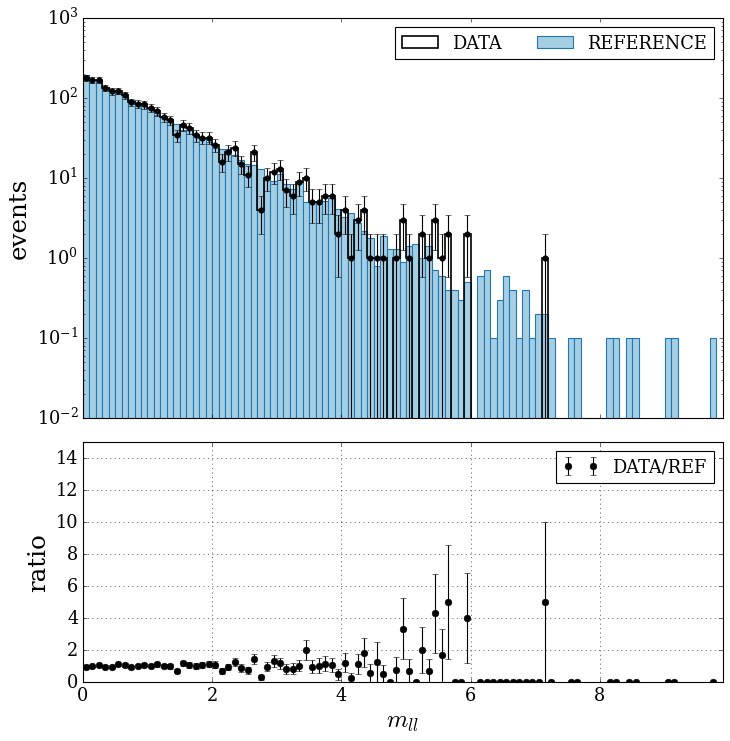

In [26]:
# plot the data
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]
weight_REF  = weight[target[:, 0]==0]
weight_DATA = weight[target[:, 0]==1]

# parameters for the plot
bins_code = {'mass': np.arange(0, 10, 0.1) }  
ymax_code = {'mass': 15 }  
xlabel_code = {'mass': r'$m_{ll}$' }  
feature_labels = list(bins_code.keys())

plot.plot_training_data(data=DATA, weight_data=weight_DATA, 
                        ref=REF, weight_ref=weight_REF, 
                        feature_labels=feature_labels, 
                        bins_code=bins_code, 
                        xlabel_code=xlabel_code, 
                        ymax_code=ymax_code,
                        save=False, save_path='', file_name='')

the DATA are generated with a distortion in shape and normalization determined by the "Scale" and "Norm" parameters

## 2) If correction=="SHAPE": evaluate the coefficients determined by the Taylor expansion model

In [27]:
if correction=="SHAPE":
    shape_syst_finder_id_list = ['scale']
    input_dim = feature.shape[1]
    polyn_degree_=2
    hidden_layers_ = (10,)
    pmodel = taylor.PolynomialModel(input_dim, polyn_degree=polyn_degree_, hidden_layers=hidden_layers_ )
    pmodel.load_state_dict(torch.load('./PolynModel_hiddenlayers10_nustd0.22_deg2_epoch1000.pth'))
    nu_std = np.std([-0.3, -0.05, 0.05, 0.3])
    input_shape = (None, input_dim)
    with torch.no_grad():
        shape_coeffs = pmodel.get_coeffs(torch.from_numpy(feature).float()) # [N, polyn_degree]
    print(shape_coeffs.shape)

torch.Size([21995, 2])


In [13]:
shape_syst_finder_id_list

['scale']

## 3) TAU model

In [14]:
##initialize parameters
NUR_S     = torch.tensor([0. ])
NUR_N     = torch.tensor([0. ])
NU_S      = torch.tensor([0. ])
NU_N      = torch.tensor([0. ])
NU_S_STD  = torch.tensor([nu_std])
SIGMA_S   = torch.tensor([sigma_s])
SIGMA_N   = torch.tensor([sigma_n]) 
input_dim = feature.shape[1]

#initialize the novelty finder
train_novelty_finder=True
Novelty_finder = gof.novelty_finder(input_dim,
                                    architecture=(1, 4, 1),
                                    activation="sigmoid",
                                    weight_clipping=9,
                                    trainable=True,
)

#initialize the systematics finders
train_norm_syst_finder=False
train_shape_syst_finder=False 
Shape_syst_finder_list = None
Norm_syst_finder = None
if correction=="NORM":
    train_norm_syst_finder=True
    Norm_syst_finder= gof.norm_syst_finder(input_shape, 
                                           nu=NUR_N, 
                                           nu_central=NU0_N, 
                                           nu_ref=NUR_N, 
                                           nu_sigma=SIGMA_N, 
                                           trainable=train_norm_syst_finder)
elif correction=="SHAPE":
    train_shape_syst_finder=True
    Shape_syst_finder_list = [
        # for now we consider only one shape effect, the scale of the distribution
        gof.shape_syst_finder(input_shape, 
                              nu=NUR_S, 
                              nu_central=NU0_S, 
                              nu_ref=NUR_S, 
                              nu_sigma=SIGMA_S,
                              nu_std=NU_S_STD,
                              polyn_degrees=polyn_degree_,
                              trainable=train_shape_syst_finder)
        # but we could add more... (this is the case in real analyses)
                         ]
    # if we choose to study the shape effects we also keep the normalization ones 
    # (SHAPE is like an upgrade of NORM)
    train_norm_syst_finder=True
    Norm_syst_finder= gof.norm_syst_finder(input_shape, 
                                           nu=NUR_N, 
                                           nu_central=NU0_N, 
                                           nu_ref=NUR_N, 
                                           nu_sigma=SIGMA_N, 
                                           trainable=train_norm_syst_finder)
    




################################## TAU MODEL
TAU = gof.NP_GOF_sys(input_shape, 
           novelty_finder=Novelty_finder, 
           shape_syst_finder_list=Shape_syst_finder_list, 
           norm_syst_finder=Norm_syst_finder,
           train_novelty_finder=train_novelty_finder, 
           train_norm_syst_finder=train_norm_syst_finder,
           train_shape_syst_finder=train_shape_syst_finder, 
           shape_syst_finder_id_list=shape_syst_finder_id_list,
           device=device)

In [15]:
# Create loaders
batch_size_ = 1000
train_ds = TensorDataset(torch.from_numpy(feature).clone().detach().float(),
                         shape_coeffs.clone().detach().float(),
                         torch.from_numpy(target).clone().detach().float())

train_loader = DataLoader(train_ds, batch_size=batch_size_, shuffle=True, num_workers=1)

# optimizer
learning_rate_ = 1e-3
optimizer = torch.optim.Adam(TAU.parameters(), lr=learning_rate_)

epoch_losses = []
# Train
for epoch in range(total_epochs_tau):
    running_loss = 0
    optimizer.zero_grad()
    for xb, sb, yb in train_loader:
        xb, sb, yb = xb.to(device), sb.to(device), yb.to(device)
        pred = TAU([xb, sb])
        loss = TAU.loss_evidence(pred, yb)        
        running_loss += loss
    running_loss += TAU.loss_auxiliary()
    running_loss.backward()

    # Now apply the optimizer, after accumulating/finding the average loss from all batches
    optimizer.step()
    # Enforce constraint
    TAU.novelty_finder.clip_weights()
    epoch_losses.append(running_loss.detach().numpy())
    if not epoch%patience_tau:
        print(f"Epoch {epoch+1}, Loss: {running_loss.detach():.4f}")
        print('nu_shape', TAU.shape_syst_finder_list[0].nu.detach().numpy()[0,0],
              'nu_norm', TAU.norm_syst_finder.nu.detach().numpy()[0],
             )

Epoch 1, Loss: 318.2936
nu_shape 0.0009999999999502885 nu_norm 0.0009999999999886408
Epoch 11, Loss: 271.1608
nu_shape 0.010971083385259124 nu_norm 0.01097058162477253
Epoch 21, Loss: 227.7491
nu_shape 0.020811858470514946 nu_norm 0.020802363027627214
Epoch 31, Loss: 188.5455
nu_shape 0.030428956064789667 nu_norm 0.030379564078317055
Epoch 41, Loss: 153.8199
nu_shape 0.03975832433859478 nu_norm 0.039603569293837466
Epoch 51, Loss: 123.6357
nu_shape 0.048762209073527615 nu_norm 0.048395160560728394
Epoch 61, Loss: 97.8913
nu_shape 0.05742032538314685 nu_norm 0.05669095805173112
Epoch 71, Loss: 76.3595
nu_shape 0.06572150071755654 nu_norm 0.06443941014547364
Epoch 81, Loss: 58.7193
nu_shape 0.07365798671190886 nu_norm 0.0715986597433874
Epoch 91, Loss: 44.5807
nu_shape 0.08122223057154783 nu_norm 0.07813638654130116
Epoch 101, Loss: 33.5081
nu_shape 0.08840532451535804 nu_norm 0.08403088694715435
Epoch 111, Loss: 25.0438
nu_shape 0.09519651936572494 nu_norm 0.08927257851910175
Epoch 121,

## 4) DELTA model

In [28]:
##initialize parameters
NUR_S     = torch.tensor([0. ])
NUR_N     = torch.tensor([0. ])
NU_S      = torch.tensor([0. ])
NU_N      = torch.tensor([0. ])
NU_S_STD  = torch.tensor([nu_std ])
SIGMA_S   = torch.tensor([sigma_s])
SIGMA_N   = torch.tensor([sigma_n]) 
input_dim = feature.shape[1]

#initialize the novelty finder
train_novelty_finder=False
Novelty_finder = None

#initialize the systematics finders
train_norm_syst_finder=False
train_shape_syst_finder=False 
Shape_syst_finder_list = None
Norm_syst_finder = None
if correction=="NORM":
    train_norm_syst_finder=True
    Norm_syst_finder= gof.norm_syst_finder(input_shape, 
                                           nu=NUR_N, 
                                           nu_central=NU0_N, 
                                           nu_ref=NUR_N, 
                                           nu_sigma=SIGMA_N, 
                                           trainable=train_norm_syst_finder)
elif correction=="SHAPE":
    train_shape_syst_finder=True
    Shape_syst_finder_list = [
        # for now we consider only one shape effect, the scale of the distribution
        gof.shape_syst_finder(input_shape, 
                              nu=NUR_S, 
                              nu_central=NU0_S, 
                              nu_ref=NUR_S, 
                              nu_sigma=SIGMA_S,
                              nu_std=NU_S_STD,
                              polyn_degrees=polyn_degree_,
                              trainable=train_shape_syst_finder)
        # but we could add more... (this is the case in real analyses)
                         ]
    # if we choose to study the shape effects we also keep the normalization ones 
    # (SHAPE is like an upgrade of NORM)
    train_norm_syst_finder=True
    Norm_syst_finder= gof.norm_syst_finder(input_shape, 
                                           nu=NUR_N, 
                                           nu_central=NU0_N, 
                                           nu_ref=NUR_N, 
                                           nu_sigma=SIGMA_N, 
                                           trainable=train_norm_syst_finder)
    








################################## DELTA MODEL
DELTA = gof.NP_GOF_sys(input_shape, 
           novelty_finder=Novelty_finder, 
           shape_syst_finder_list=Shape_syst_finder_list, 
           norm_syst_finder=Norm_syst_finder,
           train_novelty_finder=train_novelty_finder, 
           train_norm_syst_finder=train_norm_syst_finder,
           train_shape_syst_finder=train_shape_syst_finder, 
           shape_syst_finder_id_list=shape_syst_finder_id_list,
           device=device)

In [29]:
batch_size_ = 1000
learning_rate_ = 1e-3
# Create loaders
train_ds = TensorDataset(torch.from_numpy(feature).clone().detach(),
                         shape_coeffs.clone().detach(),
                         torch.from_numpy(target).clone().detach())

train_loader = DataLoader(train_ds, batch_size=batch_size_, shuffle=True, num_workers=1)

optimizer = torch.optim.Adam(DELTA.parameters(), lr=learning_rate_)

epoch_losses = []
# Train
for epoch in range(total_epochs_delta):
    running_loss = 0
    optimizer.zero_grad()
    for xb, sb, yb in train_loader:
        xb, sb, yb = xb.to(device), sb.to(device), yb.to(device)
        pred = DELTA([xb, sb])
        loss = DELTA.loss_evidence(pred, yb)        
        running_loss += loss 
    running_loss += DELTA.loss_auxiliary()
    running_loss.backward()
    # Now apply the optimizer, after accumulating/finding the average loss from all batches
    optimizer.step()
    # Enforce constraint
    epoch_losses.append(running_loss.detach().numpy())
    if not epoch%patience_delta:
        print(f"Epoch {epoch+1}, Loss: {running_loss.detach():.4f}")
        print('nu_shape', DELTA.shape_syst_finder_list[0].nu.detach().numpy()[0,0],
              'nu_norm', DELTA.norm_syst_finder.nu.detach().numpy()[0],
             )

Epoch 1, Loss: 0.0000
nu_shape 0.0009999999977536114 nu_norm -0.0009999999973704713
Epoch 11, Loss: -0.0083
nu_shape 0.0017699542058497637 nu_norm -0.0012530488742006393
Epoch 21, Loss: -0.0082
nu_shape 0.002684767406167651 nu_norm -0.002348698258882975
Epoch 31, Loss: -0.0084
nu_shape 0.001891782653140378 nu_norm -0.001818888473689309
Epoch 41, Loss: -0.0085
nu_shape 0.0023022905934642207 nu_norm -0.001775141928590729
Epoch 51, Loss: -0.0085
nu_shape 0.0022802089079407887 nu_norm -0.0019803646409945926
Epoch 61, Loss: -0.0085
nu_shape 0.0021420189986935275 nu_norm -0.0019510127700384011
Epoch 71, Loss: -0.0085
nu_shape 0.0021972634638139934 nu_norm -0.0018899434117410313
Epoch 81, Loss: -0.0085
nu_shape 0.0022345172756206414 nu_norm -0.001883568246693047
Epoch 91, Loss: -0.0085
nu_shape 0.002220109292827415 nu_norm -0.0018970026913364762
Epoch 101, Loss: -0.0085
nu_shape 0.002205784067619865 nu_norm -0.0019059219044328573
Epoch 111, Loss: -0.0085
nu_shape 0.002204486268588609 nu_norm 

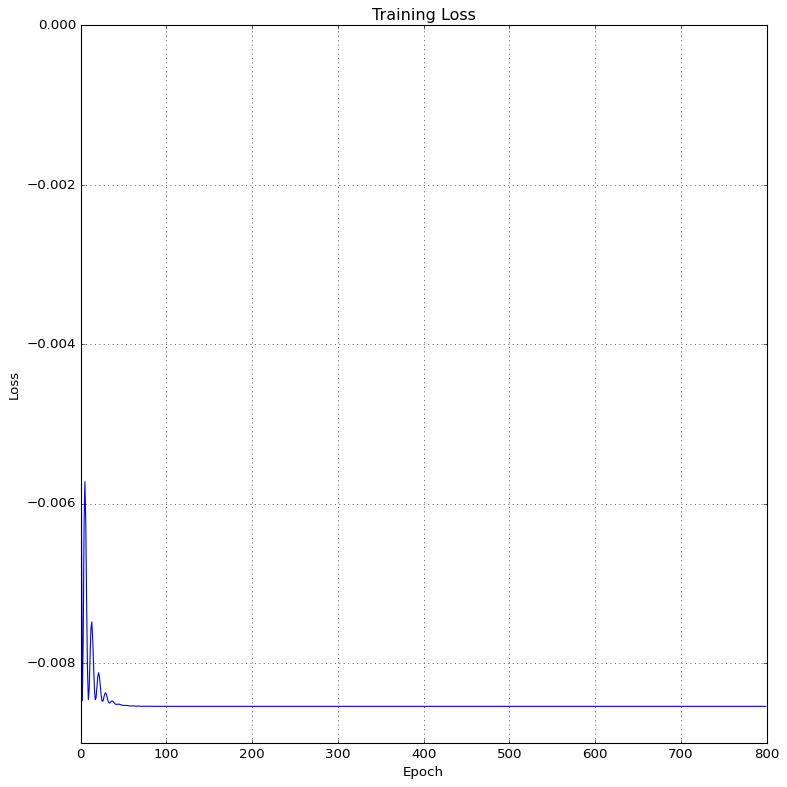

In [30]:
# plot loss history
plot.plot_loss_curves(epoch_losses)

In [31]:
pred_delta = []
pred_tau = []
targets = []
weights = []
data = []
train_loader = DataLoader(train_ds, batch_size=batch_size_, shuffle=True, num_workers=1)

with torch.no_grad():
    running_loss_tau, running_loss_delta = 0, 0
    for xb, sb, yb in train_loader:
        xb, sb, yb = xb.float().to(device), sb.to(device), yb.to(device)
        pred_delta_tmp = DELTA([xb, sb])
        pred_tau_tmp = TAU([xb, sb])
        pred_delta.append(pred_delta_tmp.detach().numpy())
        pred_tau.append(pred_tau_tmp.detach().numpy()) 
        targets.append(yb[:, 0])
        weights.append(yb[:, 1])
        data.append(xb)
        running_loss_tau += TAU.loss_evidence(pred_tau_tmp, yb).detach().numpy()  + TAU.loss_auxiliary().detach().numpy() 
        running_loss_delta += DELTA.loss_evidence(pred_delta_tmp, yb).detach().numpy()  + DELTA.loss_auxiliary().detach().numpy()
pred_delta = np.concatenate(pred_delta, axis=0)
pred_tau = np.concatenate(pred_tau, axis=0)
targets = np.concatenate(targets, axis=0)
weights = np.concatenate(weights, axis=0)
data = np.concatenate(data, axis=0)
output_tau_ref = pred_tau[targets==0]
output_delta_ref = pred_delta[targets==0]
weight_DATA = weights[targets==1]
weight_REF = weights[targets==0]
DATA = data[targets==1]
REF = data[targets==0]

tau_OBS = -2*running_loss_tau
delta_OBS = -2*running_loss_delta

/Users/gaiagrosso/Dropbox/CL&uncertainties/GOF/./utils/PLOTutils.py:142: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
/Users/gaiagrosso/Dropbox/CL&uncertainties/GOF/./utils/PLOTutils.py:143: RuntimeWarning: invalid value encountered in divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
/Users/gaiagrosso/Dropbox/CL&uncertainties/GOF/./utils/PLOTutils.py:145: RuntimeWarning: invalid value encountered in divide
  plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)


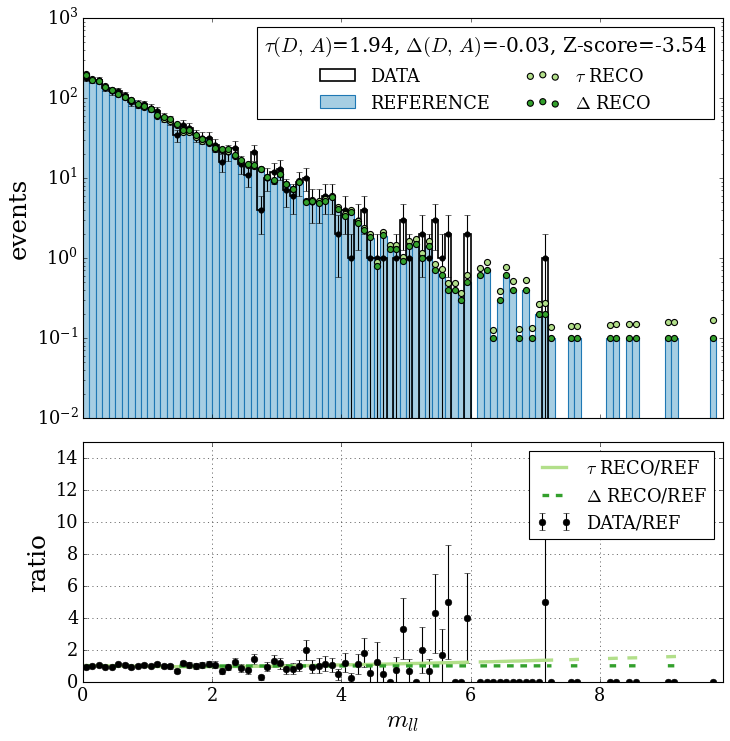

In [32]:
plot.plot_reconstruction(df=13, data=DATA, weight_data=weight_DATA, 
                         ref=REF, weight_ref=weight_REF, 
                         tau_OBS=tau_OBS, output_tau_ref=output_tau_ref,  
                         feature_labels=feature_labels, 
                         bins_code=bins_code, 
                         xlabel_code=xlabel_code, ymax_code=ymax_code,
                         delta_OBS=delta_OBS, output_delta_ref=output_delta_ref, 
                    save=False, save_path='', file_name='')

In [50]:
running_loss_tau

-64.34697306156158